In [213]:
from   category_encoders       import *
import numpy as np
import pandas as pd
from   sklearn.compose         import *
from   sklearn.experimental    import enable_iterative_imputer
from   sklearn.impute          import *
from sklearn.linear_model import LogisticRegression
from   sklearn.metrics         import mean_squared_error
from   sklearn.model_selection import train_test_split
from   sklearn.pipeline        import Pipeline
from   sklearn.preprocessing   import *
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt  

In [214]:
#load data from csv file

pokemon = pd.read_csv('https://raw.githubusercontent.com/wenyaozhang-11/ml_lab-_final_project/main/pokemon.csv')

In [215]:
#remove the label from fetures
X = pokemon.drop('is_legendary',axis=1)
# y is the label we want to predict-in this case, whether a pokemon is legendary
y = pokemon['is_legendary']

In [216]:
#create training,test data, we use 8/2 split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 999)

### Feature engineering

In [150]:
#get the categorical columns we need
categorical_columns = ['type1','type2','capture_rate']
#get the continnuous columns we need
continuous_columns=['percentage_male', 'height_m', 'weight_kg',
       'experience_growth', 'hp', 'attack', 'base_total', 'defense',
       'sp_attack', 'sp_defense', 'speed']

# continuous variable preprocessing pipeline(filling missing values and normalization)
con_pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan,strategy='median', add_indicator=True)),
                     ('scaler', StandardScaler()),
                     ])
#categorical variable preprocessing pipeline(filling missing values and one-hot encoding)
cat_pipe = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent', add_indicator=True)),
                     ('ohe', OneHotEncoder(handle_unknown='ignore'))])


# combine preprocessing together, and drop the columns with very low correlation with y label
preprocessing = ColumnTransformer([
    ('categorical', cat_pipe, categorical_columns),
                                   ('continuous' , con_pipe, continuous_columns)],remainder='drop',n_jobs=-1)

### baseline model: default logistic regression model

1.0 0.8666666666666667 0.896551724137931
[[145   1]
 [  2  13]]


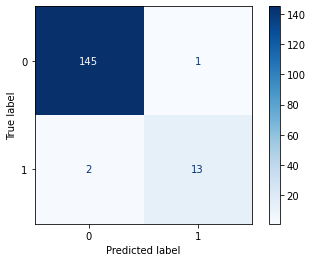

In [191]:
#build the pipeline with default logistic regression model
pipe_lg_def = Pipeline([
                 ('prep', preprocessing),
                 ('clf', LogisticRegression ())
])
#fit the model
pipe_lg_def.fit(X_train, y_train)
#predict the model
y_pred_def = pipe_lg_def.predict(X_test)
#evaluate the model
precision_def = precision_score(y_test,y_pred_def)
recall_def = recall_score(y_test,y_pred_def)
f1=(2*precision_def*recall_def)/(precision_def+recall_def)
print(precision_def,recall_def,f1)

print(confusion_matrix(y_test, y_pred_def))
plot_confusion_matrix(pipe_lg_def,X_test, y_test,cmap='Blues') 
plt.show()

### ExtraTreesClassifier  Search

In [169]:
#build the pipeline for extra tress classfier model
pipe_et = Pipeline([
                 ('prep', preprocessing),
                 ('clf', ExtraTreesClassifier ())
])

# set hyperparameters search space of ExtraTreesClassifier

hyperparameters_et = dict(clf__n_estimators = range(50, 300, 50),
                          clf__criterion =['gini', 'entropy'],
                        clf__max_depth = range(50, 300, 50),
                          clf__max_features=['auto', 'sqrt', 'log2'],
                            clf__class_weight=['balanced', 'balanced_subsample'])

# random search for the best model of ExtraTreesClassifier
clf_rand_cv_et = RandomizedSearchCV(estimator=pipe_et, 
                              param_distributions=hyperparameters_et, 
                              n_iter=25, 
                              cv=5, 
                              n_jobs=-1,
                              verbose=True)
clf_rand_cv_et.fit(X_train, y_train)
# get the best model of extra trees classfier model
print(clf_rand_cv_et.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'clf__n_estimators': 100, 'clf__max_features': 'auto', 'clf__max_depth': 150, 'clf__criterion': 'gini', 'clf__class_weight': 'balanced'}


In [172]:
# fit the best model of ExtraTreesClassifier
pipe_et = Pipeline([
                 ('prep', preprocessing),
                 ('clf', ExtraTreesClassifier (n_estimators=100,
                                                max_features='auto',
                                                max_depth= 150,
                                                 criterion='gini',
                                                 class_weight ='balanced'))
])
pipe_et.fit(X_train, y_train.values.ravel())
y_pred_et = pipe_et.predict(X_test)


In [193]:
# evaluation metrics of ExtraTreesClassifier

precision = precision_score(y_test,y_pred_et)
recall = recall_score(y_test,y_pred_et)
f1=(2*precision*recall)/(precision+recall)
print(precision,recall,f1)
print(confusion_matrix(y_test, y_pred_et))

1.0 0.8666666666666667 0.9285714285714286
[[146   0]
 [  2  13]]


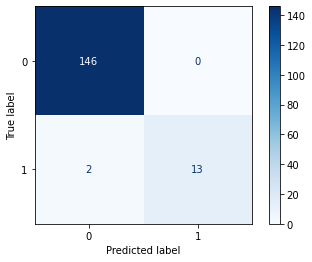

In [179]:
plot_confusion_matrix(pipe_et,X_test, y_test,cmap='Blues') 
plt.show()

### Random Forest Search

In [126]:
#build the pipeline for random forest model
pipe_rf = Pipeline([
                 ('prep', preprocessing),
                 ('clf', RandomForestClassifier())
])

# set hyperparameters search space of random forest
hyperparameters = dict(
                        clf__n_estimators= range(50, 300, 50),
                        clf__criterion=['gini', 'entropy'],
                        clf__min_samples_leaf= [1, 2],
                        clf__max_depth=range(50, 300, 50),
                        clf__max_features=['auto', 'sqrt', 'log2'],
                        clf__class_weight=['balanced', 'balanced_subsample'])

# random search for the best model of random forest
clf_rand_cv = RandomizedSearchCV(estimator=pipe_rf, 
                              param_distributions=hyperparameters, 
                              n_iter=25, 
                              cv=5, 
                              n_jobs=-1,
                              verbose=True)
clf_rand_cv.fit(X_train, y_train)
#get the best model for random forest
print(clf_rand_cv.best_params_)



Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'clf__n_estimators': 150, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 250, 'clf__criterion': 'gini', 'clf__class_weight': 'balanced_subsample'}


In [167]:
# fit the best model of random forest
pipe_rf = Pipeline([
                 ('prep', preprocessing),
                 ('clf', RandomForestClassifier (n_estimators=150,
                                                min_samples_leaf=2,
                                                max_features='sqrt',
                                                max_depth=250,
                                                criterion='gini',
                                                class_weight='balanced_subsample'))
])
pipe_rf.fit(X_train, y_train.values.ravel())
y_pred_rf = pipe_rf.predict(X_test)

In [194]:
# evaluation metrics of random forest
precision = precision_score(y_test,y_pred_rf)
recall = recall_score(y_test,y_pred_rf)
f1=(2*precision*recall)/(precision+recall)
print(precision,recall,f1)
print(confusion_matrix(y_test, y_pred_rf))

0.9375 1.0 0.967741935483871
[[145   1]
 [  0  15]]


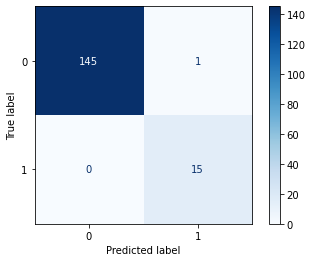

In [178]:
plot_confusion_matrix(pipe_rf,X_test, y_test,cmap='Blues') 
plt.show()

### result

In [196]:

# the best model is Random forest with precision:0.94, recall:1, f1_score:0.97
#the hyperparameters combo is:{'clf__n_estimators': 150, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 250, 'clf__criterion': 'gini', 'clf__class_weight': 'balanced_subsample'}
# the random forest and extra trees classfier both work better than the default model.
#the attributes that reflect pokemon’s qualities of ‘rare and powerful’ work well on predicting what is a legendary Pokemon
 